In [7]:
import numpy as np
import pandas as pd
import ipdb
import pickle
import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.cde_loss import cde_loss
from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm, multivariate_normal
from scipy.integrate import simps
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from scipy.special import expit, logit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from copy import copy

from matplotlib.ticker import NullFormatter
import seaborn as sns

# omitted variable bias
# $Y \sim N(X_1+X_2,\ \ 1)$
# $X_1,X_2 \sim N(0,1),\ \ \rho(X_1,X_2) = 0.8$

In [2]:
def sample_X_Y_Z(rho=0.1, size=10000, var1=1, std2=1):
    joint_data = multivariate_normal.rvs(mean=[0,0], cov=var1*np.array([[1,rho],[rho,1]]), size=size)
    X_data = joint_data[:,0]
    Z_data = joint_data[:,1]
    Y_data = np.random.normal(loc=X_data+Z_data, scale=std2)
    return X_data, Y_data, Z_data

In [3]:
def get_true_conditional_dist(X, Z, std=1):
    dist = norm(loc=X+Z, scale=std)
    return dist

In [210]:
# sample points
rho = 0.8  #-0.2
size = 15500  # train 10000, val 5000, test 500
X_data, Y_data, Z_data = sample_X_Y_Z(rho=rho, size=size)

Text(0, 0.5, '$X_2$')

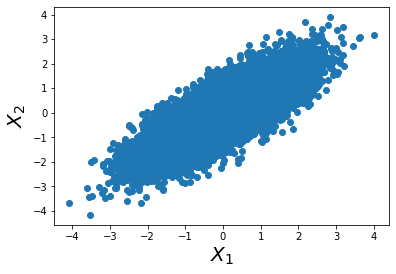

In [211]:
plt.scatter(X_data, Z_data)
plt.xlabel("$X_1$", fontsize=20)
plt.ylabel("$X_2$", fontsize=20)

# fit correct NNKCDE

In [214]:
n_train = 10000
n_val = 5000
XZ_train = np.array([[x,z] for x,z in zip(X_data[:n_train], Z_data[:n_train])])
XZ_val = np.array([[x,z] for x,z in zip(X_data[n_train:n_train+n_val], Z_data[n_train:n_train+n_val])])
Y_train = np.array(Y_data[:n_train])
Y_val = np.array(Y_data[n_train:n_train+n_val])

In [10]:
def fit_NNKCDE(k=50, x_train=XZ_train, z_train=Y_train):
    model = nnkcde.NNKCDE(k=k)
    model.fit(x_train=x_train, z_train=z_train)
    return model

In [86]:
def tune_k_bw(bws=np.linspace(0.1,0.9,9), ks=np.arange(20,110,10), x_train=XZ_train, z_train=Y_train,
              x_val=XZ_val, z_val=Y_val, n_grid=151, z_min=-15, z_max=15):
    z_grid = np.linspace(z_min, z_max, n_grid)
    CDE_losses = {}
    CDE_loss_SEs = {}
    for bw in bws:
        print(bw)
        CDE_losses[bw] = {}
        CDE_loss_SEs[bw] = {}
        for k in ks:
            print(k)
            model = fit_NNKCDE(k=k, x_train=x_train, z_train=z_train)
            cde_val = model.predict(x_val, z_grid, bandwidth=bw)
            loss, se = cde_loss(cde_val, z_grid, z_val)
            CDE_losses[bw][k] = loss
            CDE_loss_SEs[bw][k] = se
    return pd.DataFrame(CDE_losses), pd.DataFrame(CDE_loss_SEs)

In [55]:
CDE_losses, CDE_loss_SEs = tune_k_bw(bws=np.linspace(0.1,0.9,9), ks=np.arange(70,160,10), x_train=XZ_train, z_train=Y_train,
                                     n_grid=151, z_min=-15, z_max=15)

0.1
70
80
90
100
110
120
130
140
150
0.2
70
80
90
100
110
120
130
140
150
0.30000000000000004
70
80
90
100
110
120
130
140
150
0.4
70
80
90
100
110
120
130
140
150
0.5
70
80
90
100
110
120
130
140
150
0.6
70
80
90
100
110
120
130
140
150
0.7000000000000001
70
80
90
100
110
120
130
140
150
0.8
70
80
90
100
110
120
130
140
150
0.9
70
80
90
100
110
120
130
140
150


In [65]:
~CDE_losses[CDE_losses == CDE_losses.min().min()].isna()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
70,False,False,False,False,False,False,False,False,False
80,False,False,False,False,False,False,False,False,False
90,False,False,False,False,False,False,False,False,False
100,False,False,False,False,False,False,False,False,False
110,False,False,False,False,False,False,False,False,False
120,False,False,False,False,False,False,False,False,False
130,False,False,False,True,False,False,False,False,False
140,False,False,False,False,False,False,False,False,False
150,False,False,False,False,False,False,False,False,False


In [215]:
k = 130
bw = 0.4
model = nnkcde.NNKCDE(k=k)
model.fit(x_train=XZ_train, z_train=Y_train)
n_grid = 151
z_grid = np.linspace(-15, 15, n_grid)

In [216]:
n_test = 500
XZ_test = np.array([[x,z] for x,z in zip(X_data[-n_test:], Z_data[-n_test:])])
Y_test = np.array(Y_data[-n_test:])

In [217]:
%%time

cde_test = model.predict(XZ_test, z_grid, bandwidth=bw)

Wall time: 360 ms


In [218]:
cde_test.shape

(500, 151)

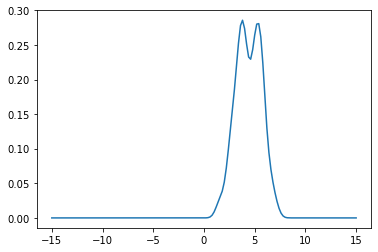

In [219]:
plt.plot(z_grid, cde_test[0])

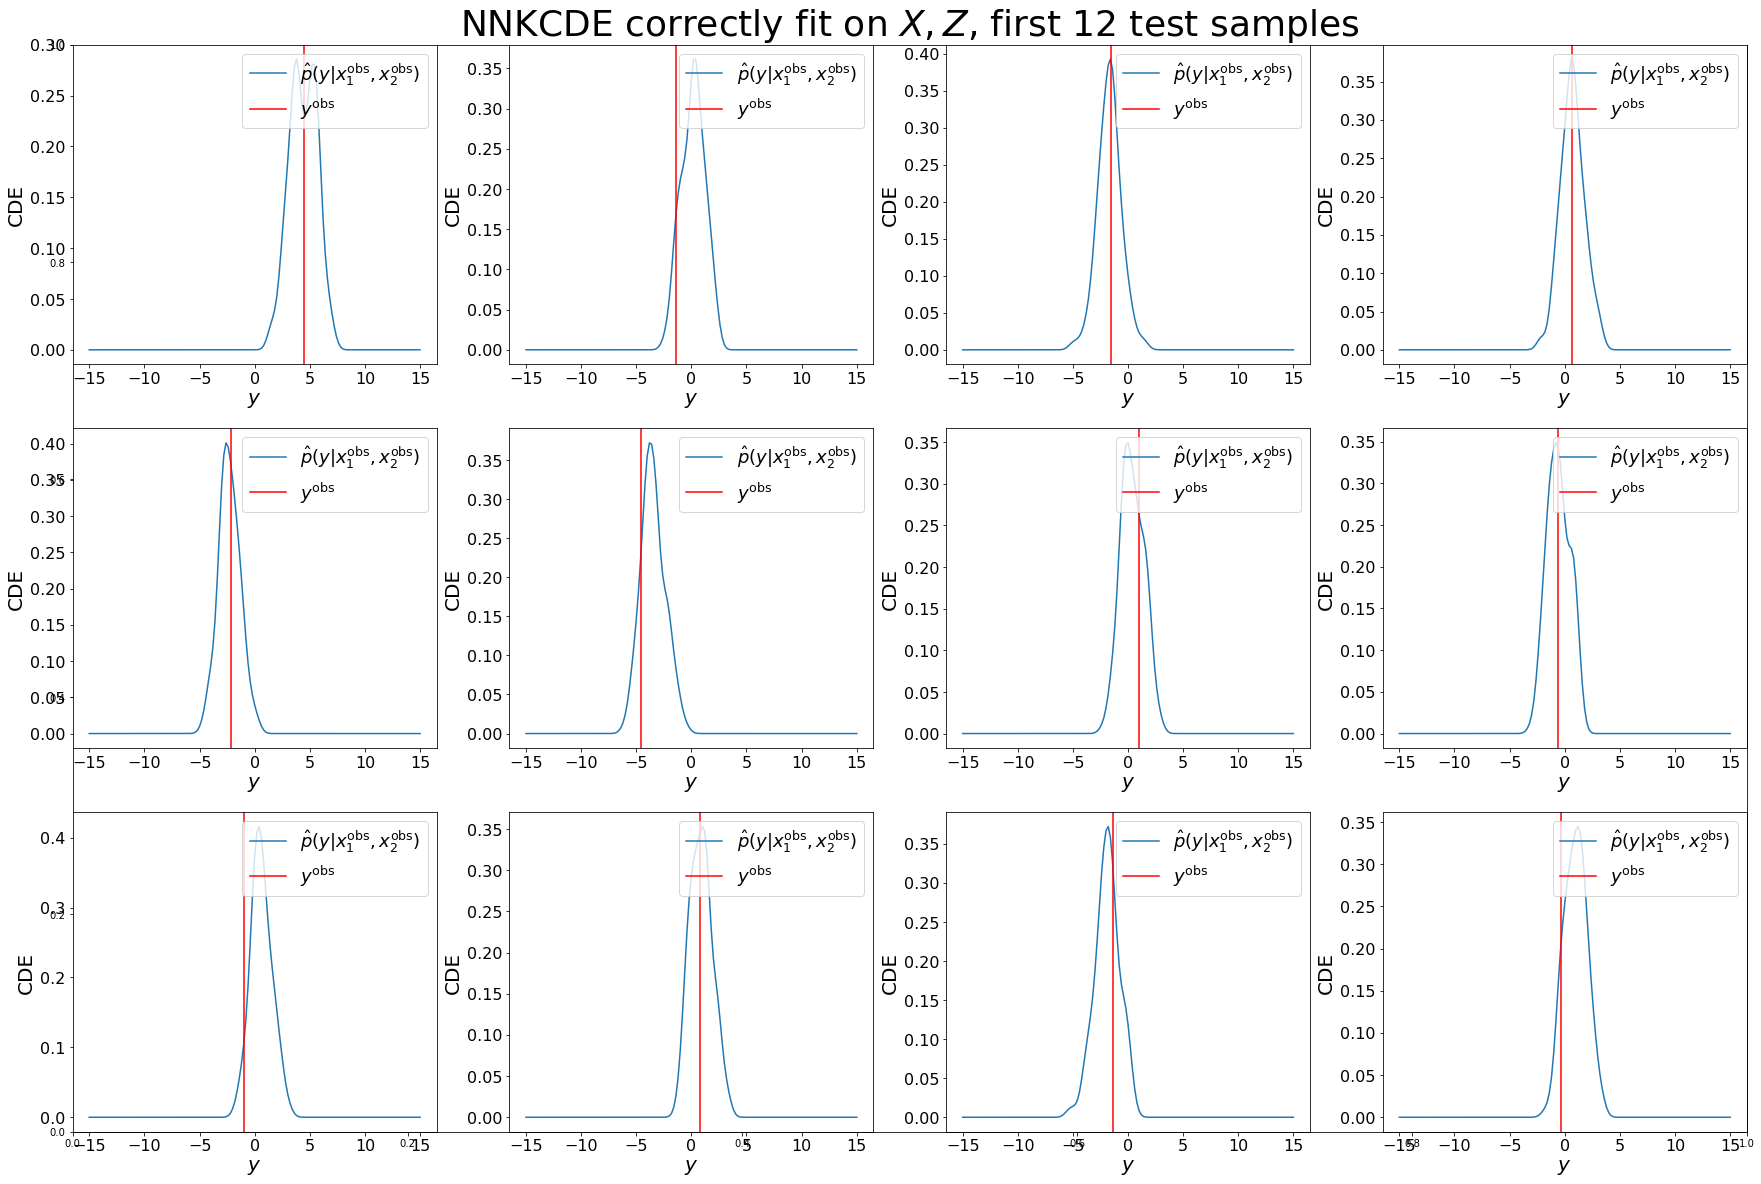

In [220]:
fig = plt.figure(figsize=(30, 20))
plt.title("NNKCDE correctly fit on $X,Z$, first 12 test samples", fontsize=36)
for jj, cde_predicted in enumerate(cde_test[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(y| x_1^{\rm obs}, x_2^{\rm obs})$')
    plt.axvline(Y_test[jj], color='red', label=r'$y^{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'$y$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 18})
plt.show()

In [221]:
print(type(cde_test), cde_test.shape)

den_integral = simps(cde_test[0, :], x=z_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (500, 151)
Integral of the first density integrates to: 1.00


# fit incorrect NNKCDE

In [222]:
n_train = 10000
n_val = 5000
X_train = np.array(X_data[:n_train])
X_val = np.array(X_data[n_train:n_train+n_val])
Y_train = np.array(Y_data[:n_train])
Y_val = np.array(Y_data[n_train:n_train+n_val])

In [87]:
CDE_losses_X, CDE_loss_SEs_X = tune_k_bw(bws=np.linspace(0.1,0.9,9), ks=np.arange(70,160,10), x_train=X_train, z_train=Y_train,
                                         x_val=X_val, n_grid=151, z_min=-15, z_max=15)

0.1
70
80
90
100
110
120
130
140
150
0.2
70
80
90
100
110
120
130
140
150
0.30000000000000004
70
80
90
100
110
120
130
140
150
0.4
70
80
90
100
110
120
130
140
150
0.5
70
80
90
100
110
120
130
140
150
0.6
70
80
90
100
110
120
130
140
150
0.7000000000000001
70
80
90
100
110
120
130
140
150
0.8
70
80
90
100
110
120
130
140
150
0.9
70
80
90
100
110
120
130
140
150


In [88]:
~CDE_losses_X[CDE_losses_X == CDE_losses_X.min().min()].isna()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
70,False,False,False,False,False,False,False,False,False
80,False,False,False,False,False,False,False,False,False
90,False,False,False,False,False,False,False,False,False
100,False,False,False,False,False,False,False,False,False
110,False,False,False,False,False,False,False,False,False
120,False,False,False,False,False,False,False,False,False
130,False,False,False,False,False,False,False,False,False
140,False,False,False,False,False,False,False,False,False
150,False,False,False,False,True,False,False,False,False


In [223]:
k = 150
bw = 0.5
model_X = nnkcde.NNKCDE(k=k)
model_X.fit(x_train=X_train, z_train=Y_train)
n_grid = 151
z_grid = np.linspace(-15, 15, n_grid)

In [224]:
X_test = np.array(X_data[-n_test:])

In [225]:
%%time

cde_test_X = model_X.predict(X_test, z_grid, bandwidth=bw)

Wall time: 361 ms


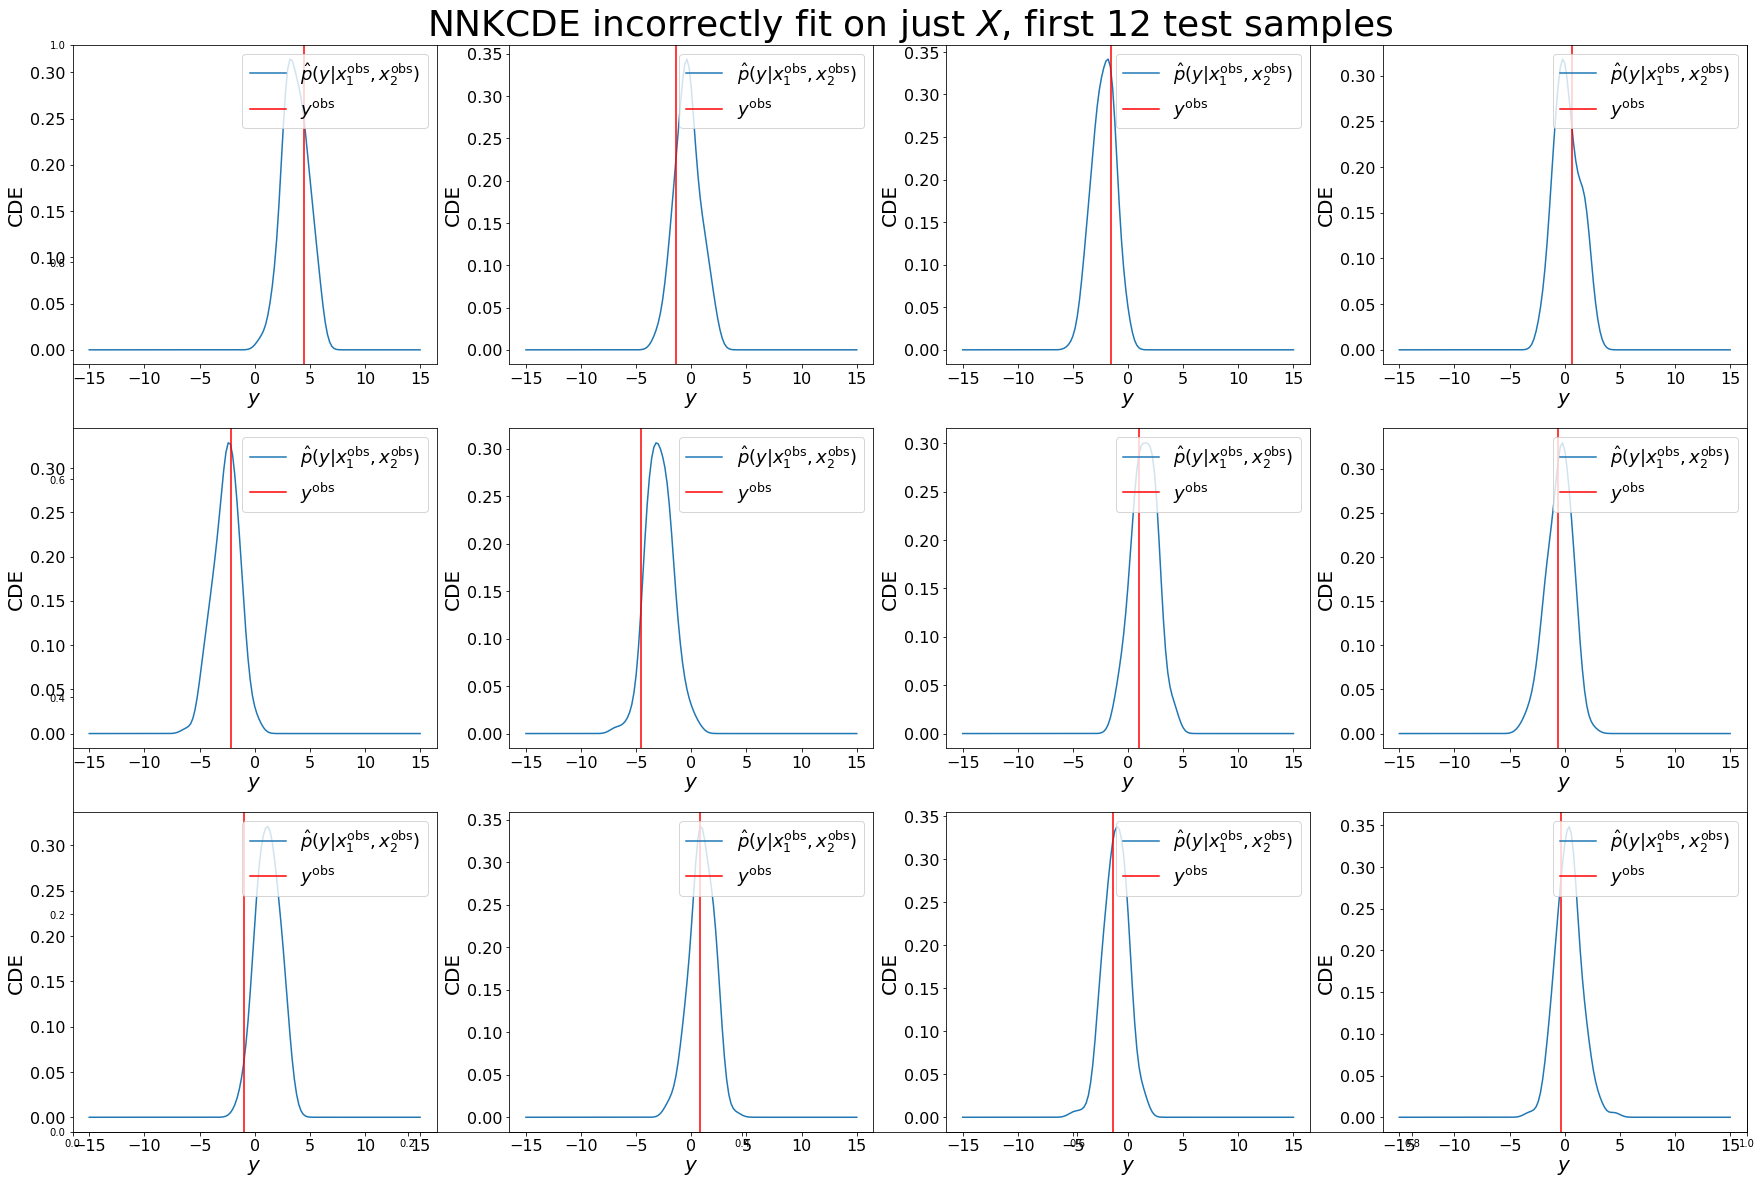

In [226]:
fig = plt.figure(figsize=(30, 20))
plt.title("NNKCDE incorrectly fit on just $X$, first 12 test samples", fontsize=36)
for jj, cde_predicted in enumerate(cde_test_X[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(y| x_1^{\rm obs}, x_2^{\rm obs})$')
    plt.axvline(Y_test[jj], color='red', label=r'$y^{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'$y$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 18})
plt.show()

In [227]:
print(type(cde_test_X), cde_test_X.shape)

den_integral = simps(cde_test_X[0, :], x=z_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (500, 151)
Integral of the first density integrates to: 1.00


# PIT uniformity test: all NNKCDEs pass

In [228]:
pit_values = 1 - cdf_coverage(cde_test, z_grid, Y_test)
pit_values_X = 1 - cdf_coverage(cde_test_X, z_grid, Y_test)

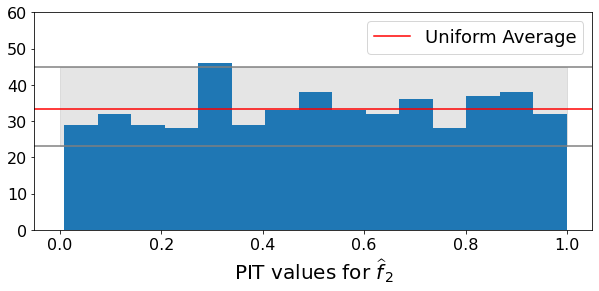

In [372]:
# good model
fig_pit = plot_with_uniform_band(values=pit_values, ci_level=0.95, x_label='PIT values for $\widehat f_2$', n_bins=15, ylim=[0, 60])
fig_pit

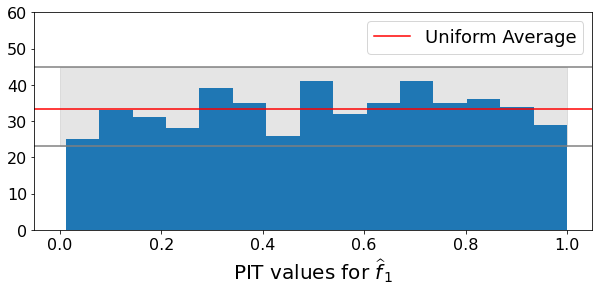

In [373]:
# bad model
fig_pit = plot_with_uniform_band(values=pit_values_X, ci_level=0.95, x_label='PIT values for $\widehat f_1$', n_bins=15, ylim=[0, 60])
fig_pit

In [233]:
pit_values_dict = {'XZ': pit_values, 'X': pit_values_X}

In [234]:
#with open('pit_values_dict_20210209_n500.pkl', 'wb') as handle:
#    pickle.dump(pit_values_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [235]:
#np.save('XZ_test_20210209_n500.npy', XZ_test)

# saved $\hat r$ from MC samples, to build CIs

In [263]:
with open("all_rhat_classifiers_2021-02-10-00-45.pkl", 'rb') as handle:
    all_rhat_classifiers = pickle.load(handle)

C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [292]:
def get_confidence_band_range(n_trials=1000, name='XZ', alpha=0.1, points=[[1,2]], q=0.05):
    sample = [all_rhat_classifiers[i][name][alpha].predict_proba(points)[:, 1][0] for i in range(n_trials)]
    return [np.quantile(sample, q=q), np.quantile(sample, q=1-q)]

# fixed $\mathbf{x}_i$, QQ plot of $\hat r_\alpha(\mathbf{x}_i)$ vs. $\alpha$

In [380]:
points = np.array([[-1,0],[0,0],[1,0],[0,1],[0,-1]])
alphas = np.linspace(0.01, 0.99, 99)

In [381]:
rhat_alphas_xi = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    rhat_alphas_xi[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=XZ_test, y=ind_values)
        rhat_alphas_xi[name][alpha] = rhat.predict_proba(points)[:, 1]

working on classifier XZ
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99
working on classifier X
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.

In [293]:
confidence_qqplot = {}
confidence_qqplot['XZ'] = np.array([get_confidence_band_range(name='XZ', alpha=i, points=points)
                                    for i in all_rhat_classifiers[0]['XZ'].keys()])
confidence_qqplot['X'] = np.array([get_confidence_band_range(name='X', alpha=i, points=points)
                                   for i in all_rhat_classifiers[0]['XZ'].keys()])

## (-1, 0)

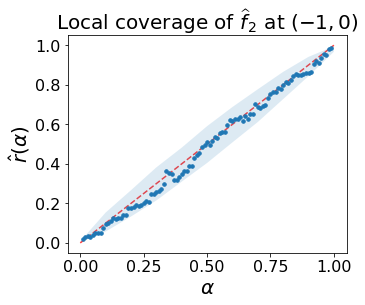

In [379]:
use_series = pd.DataFrame(rhat_alphas_xi['XZ']).T[0]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 confidence_qqplot['XZ'][:, 0],
                 confidence_qqplot['XZ'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_2$ at $(-1,0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

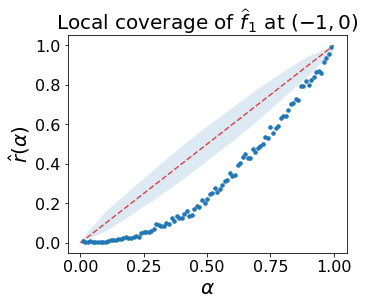

In [378]:
use_series = pd.DataFrame(rhat_alphas_xi['X']).T[0]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_1$ at $(-1,0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

## (0, 0)

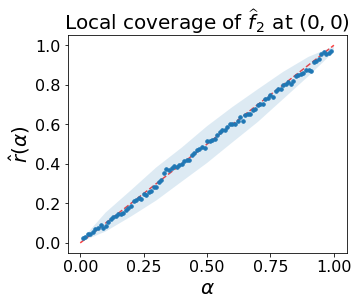

In [377]:
use_series = pd.DataFrame(rhat_alphas_xi['XZ']).T[1]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 confidence_qqplot['XZ'][:, 0],
                 confidence_qqplot['XZ'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_2$ at $(0,0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

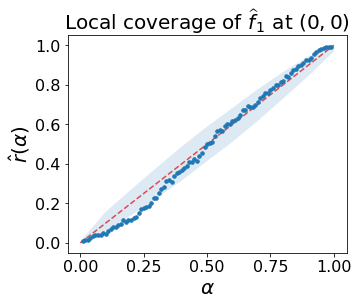

In [376]:
use_series = pd.DataFrame(rhat_alphas_xi['X']).T[1]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_1$ at $(0,0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

## (1, 0)

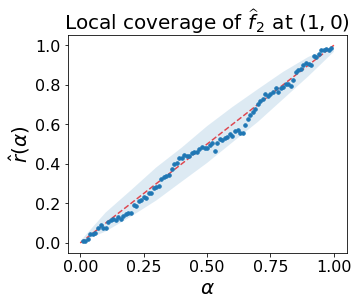

In [374]:
use_series = pd.DataFrame(rhat_alphas_xi['XZ']).T[2]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 confidence_qqplot['XZ'][:, 0],
                 confidence_qqplot['XZ'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_2$ at $(1, 0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

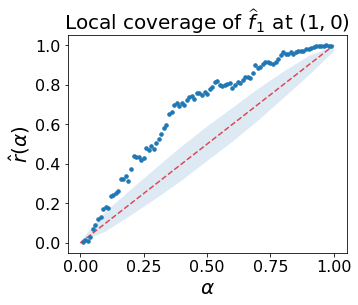

In [375]:
use_series = pd.DataFrame(rhat_alphas_xi['X']).T[2]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_1$ at $(1, 0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

## (0, 1)

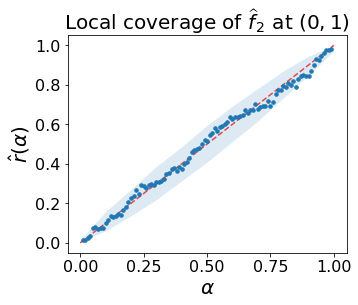

In [389]:
use_series = pd.DataFrame(rhat_alphas_xi['XZ']).T[3]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 confidence_qqplot['XZ'][:, 0],
                 confidence_qqplot['XZ'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_2$ at $(0,1)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

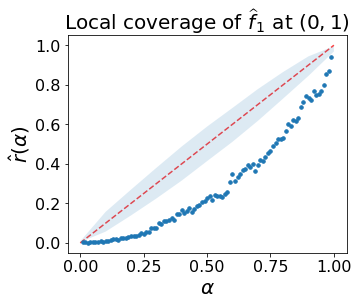

In [382]:
use_series = pd.DataFrame(rhat_alphas_xi['X']).T[3]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_1$ at $(0,1)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

## (0, -1)

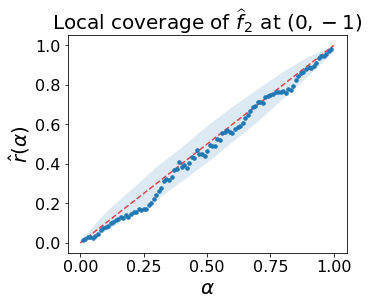

In [390]:
use_series = pd.DataFrame(rhat_alphas_xi['XZ']).T[4]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 confidence_qqplot['XZ'][:, 0],
                 confidence_qqplot['XZ'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_2$ at $(0,-1)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

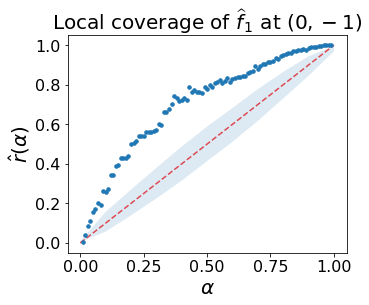

In [384]:
use_series = pd.DataFrame(rhat_alphas_xi['X']).T[4]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_1$ at $(0,-1)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

# heat map of $T_i = \frac{1}{|G|} \sum_{\alpha \in G} (\hat r_\alpha(\mathbf{x}_i) - \alpha)^2$

In [236]:
with open("Ti_values_2021-02-09-22-44.pkl", 'rb') as handle:
    Ti_values = pickle.load(handle)
with open("all_rhat_alphas_2021-02-09-22-44.pkl", 'rb') as handle:
    all_rhat_alphas = pickle.load(handle)

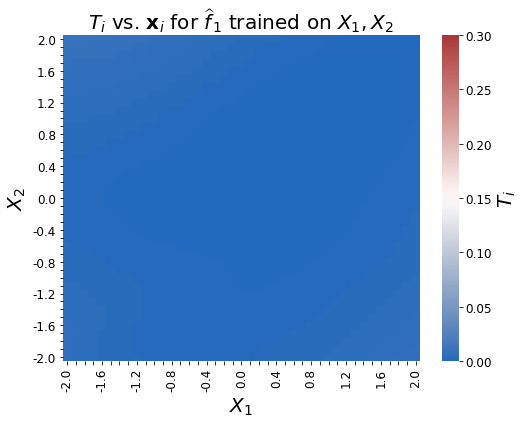

In [240]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['XZ'].values.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\widehat f_1$ trained on $X_1,X_2$", fontsize=20)
plt.xlabel('$X_1$', fontsize=20)
plt.ylabel('$X_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

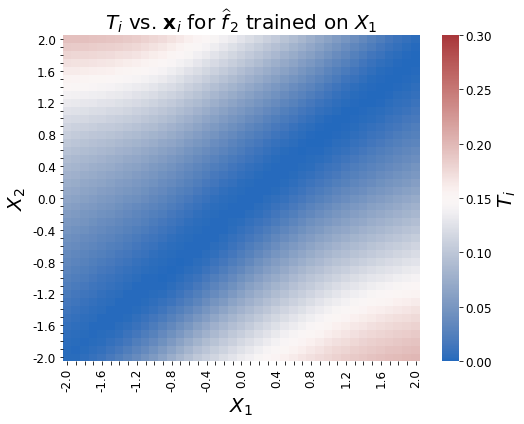

In [239]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['X'].values.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\widehat f_2$ trained on $X_1$", fontsize=20)
plt.xlabel('$X_1$', fontsize=20)
plt.ylabel('$X_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# global p-value based on $T_i$

In [242]:
with open("all_unif_Ti_values_2021-02-10-00-45.pkl", 'rb') as handle:
    all_unif_Ti_values = pickle.load(handle)

In [243]:
global_pvalues = sum([1* (pd.DataFrame(Ti_values).mean() < pd.DataFrame(all_unif_Ti_values[i]).mean())
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
global_pvalues

XZ    0.894
X     0.004
dtype: float64

# local p-values based on $T_i$: local CvM test

In [244]:
all_rhat_classifiers[0]['XZ']

{0.0: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 0.1: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_

In [245]:
all_rhat_classifiers[0]['XZ'][0.1].predict_proba([[1,2]])

array([[0.97177727, 0.02822273]])

In [246]:
all_pvalues = sum([1* (pd.DataFrame(Ti_values) < pd.DataFrame(all_unif_Ti_values[i]))
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
all_pvalues

,XZ,X
0,0.243,0.579
1,0.252,0.409
2,0.278,0.193
3,0.313,0.072
4,0.339,0.027
...,...,...
1676,0.978,0.004
1677,0.987,0.004
1678,0.989,0.014
1679,0.987,0.070


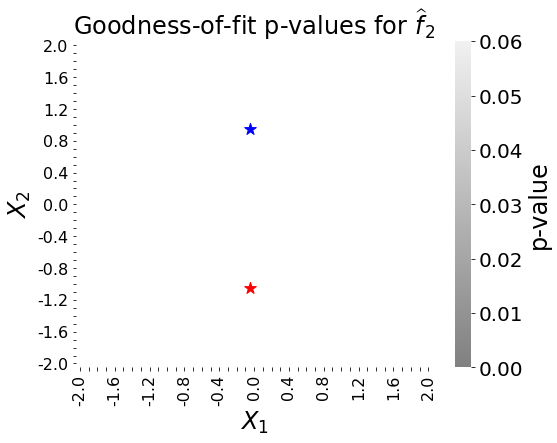

In [392]:
fig, ax = plt.subplots(figsize=(8,6))
val_max = 0.06

#define the colormap with clipping values
#my_cmap = copy(plt.cm.Greens_r)
my_cmap = sns.light_palette("grey", reverse=True, as_cmap=True)
my_cmap.set_over("white")
sns.heatmap(all_pvalues['XZ'].values.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap=my_cmap, vmin=0, vmax=val_max)#vmax=1)
ax.invert_yaxis()

ax.scatter(20, 30, marker='*', s=150, color='blue')
ax.scatter(20, 10, marker='*', s=150, color='red')

plt.title("Goodness-of-fit p-values for $\widehat f_2$", fontsize=24)
plt.xlabel('$X_1$', fontsize=24)
plt.ylabel('$X_2$', fontsize=24)

ax.tick_params(axis='both', which='major', labelsize=16)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(24)
cbar_axes.tick_params(labelsize=20)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

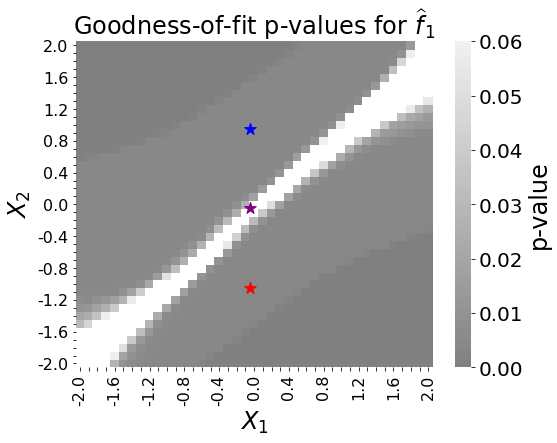

In [386]:
fig, ax = plt.subplots(figsize=(8,6))
val_max = 0.06

#define the colormap with clipping values
#my_cmap = copy(plt.cm.Greens_r)
#my_cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.6, light=1, reverse=True, as_cmap=True)
my_cmap = sns.light_palette("grey", reverse=True, as_cmap=True)
my_cmap.set_over("white")

sns.heatmap(all_pvalues['X'].values.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap=my_cmap, vmin=0, vmax=val_max
           )
ax.invert_yaxis()

ax.scatter(20, 30, marker='*', s=150, color='blue')
ax.scatter(20, 20, marker='*', s=150, color='purple')
ax.scatter(20, 10, marker='*', s=150, color='red')

plt.title("Goodness-of-fit p-values for $\widehat f_1$", fontsize=24)
plt.xlabel('$X_1$', fontsize=24)
plt.ylabel('$X_2$', fontsize=24)

ax.tick_params(axis='both', which='major', labelsize=16)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(24)
cbar_axes.tick_params(labelsize=20)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# sanity checks

In [251]:
from sklearn.linear_model import LinearRegression

In [252]:
f1_data = np.array([(x,z) for x,z in zip(X_data, Z_data)])
f2_data = X_data.reshape(-1,1)

In [253]:
reg_f1 = LinearRegression().fit(f1_data, Y_data)
reg_f2 = LinearRegression().fit(f2_data, Y_data)

In [254]:
reg_f1.coef_

array([1.00980614, 0.97828784])

In [255]:
reg_f1.intercept_

0.0005333291369949006

In [256]:
reg_f2.coef_

array([1.79387027])

In [257]:
reg_f2.intercept_

0.0028430177610264786

In [258]:
f1_predictions = reg_f1.predict(grid)
f1_predictions

array([-3.97565462, -3.87467401, -3.77369339, ...,  3.77476005,
        3.87574066,  3.97672128])

In [259]:
f2_predictions = reg_f2.predict(grid[:,0].reshape(-1,1))
f2_predictions

array([-3.58489752, -3.40551049, -3.22612347, ...,  3.2318095 ,
        3.41119653,  3.59058356])

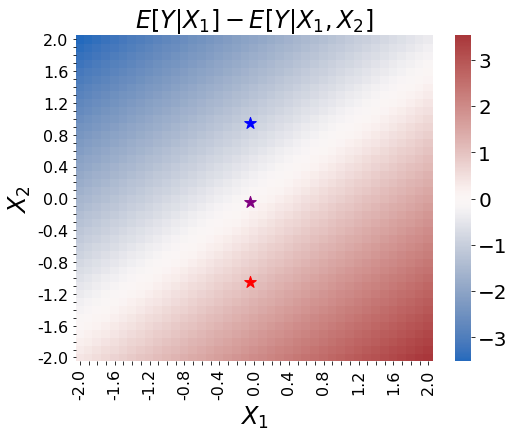

In [387]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap((f2_predictions - f1_predictions).reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cmap='vlag') #, vmin=0, vmax=0.3)
ax.invert_yaxis()

ax.scatter(20, 30, marker='*', s=150, color='blue')
ax.scatter(20, 20, marker='*', s=150, color='purple')
ax.scatter(20, 10, marker='*', s=150, color='red')

plt.title("$E[Y|X_1] - E[Y|X_1,X_2]$", fontsize=24)
plt.xlabel('$X_1$', fontsize=24)
plt.ylabel('$X_2$', fontsize=24)

ax.tick_params(axis='both', which='major', labelsize=16)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=20)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# omitted variable bias
# $Y \sim N(X_1+X_2,\ \ 1)$
# $X_1,X_2 \sim N(0,1),\ \ \textrm{corr}(X_1,X_2) = 0.8$

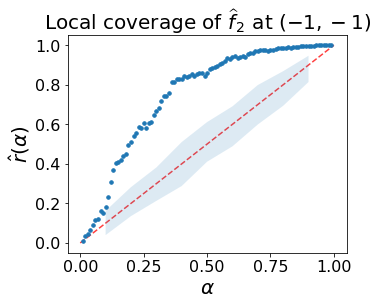

In [396]:
# CDE FIT WHEN X2 > 0

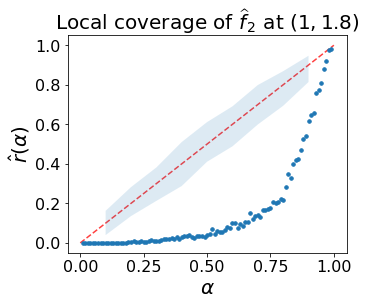

In [398]:
# CDE FIT WHEN X2 < 0

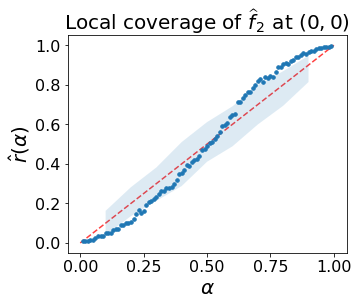

In [392]:
# CDE IS NARROW-TAILED VS. REAL DATA AT (0,0)

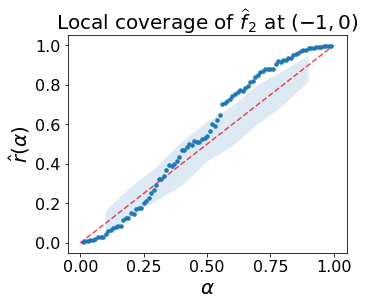

In [399]:
use_series = pd.DataFrame(rhat_alphas_xi['X']).T[5]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0.1,0.9,9),
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_2$ at $(-1, 0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

## (1, 0)

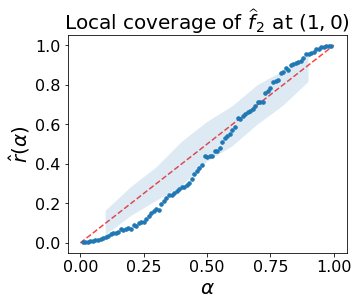

In [400]:
use_series = pd.DataFrame(rhat_alphas_xi['X']).T[6]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0.1,0.9,9),
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_2$ at $(1, 0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

## (0, 1)

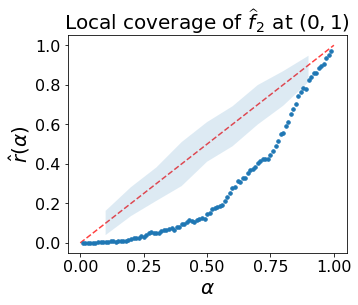

In [401]:
use_series = pd.DataFrame(rhat_alphas_xi['X']).T[7]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0.1,0.9,9),
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_2$ at $(0, 1)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

## (0, -1)

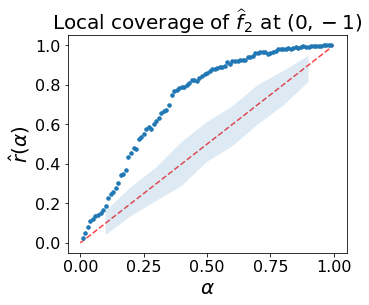

In [ ]:
use_series = pd.DataFrame(rhat_alphas_xi['X']).T[8]

use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


# confidence bands
plt.fill_between(np.linspace(0.1,0.9,9),
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )

plt.title("Local coverage of $\widehat f_2$ at $(0, -1)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)